# Assignment 1: ML Engineering 1

In [2]:
# enter your name and UFL email address
name = 'enter your name'
email = 'enter your email'

name = 'solution' # ###- 
email = 'solution' # ###- 

In [20]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 1 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time
    import tempfile 

    import numpy as np
    import pandas as pd

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    import tensorflow as tf


    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### TF version: ' + tf.__version__)
    print('### Keras version: ' + tf.keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 1 -- name: solution, email: solution

### Python version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
### TF version: 2.4.0
### Keras version: 2.4.0
------------


In [21]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 17

# deterministic seed for reproducibility
##rng = np.random.default_rng(seed)  # best practice but not fully implemented in scikit-learn
np.random.seed(seed)

## Part 1: Loading and Pre-processing Data

### Loading data

In [22]:
# Use pandas to load the data from compressed CSV
df1 = pd.read_csv('../data/adult.data.gz', compression='gzip', header=0, na_values='?', sep=' *, *', skipinitialspace=True, engine='python')
df2 = pd.read_csv('../data/adult.test.gz', compression='gzip', header=0, na_values='?',sep=' *, *', skipinitialspace=True, engine='python')

In [23]:
# Check that we loaded the data as expected
df1_expected_shape = (32561,15)
df2_expected_shape = (16281,15)

assert df1.shape == df1_expected_shape, 'Unexpected shape of df1!'
assert df2.shape == df2_expected_shape, 'Unexpected shape of df2!'

In [24]:
# Merge df1 and df2 for pre-processing and cleaning
dfraw = df1.append(df2, ignore_index=True, sort=False)
assert dfraw.shape == (df1_expected_shape[0]+df2_expected_shape[0],15)

In [25]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [26]:
# Let's look at a few rows of our dataframe
dfraw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Cleaning & pre-processing data

In [27]:
## header right now: age (num), workclass (cat), fnlwgt (num), education (cat) education-num (num), marital-status (cat), occupation (cat), relationship (cat), race (cat), sex (cat), capital-gain (num), capital-loss (num), hours-per-week (num), native-country (cat), income (cat)
dfraw.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [28]:
# Let's start cleaning up the data
df = dfraw.copy()

# Let's get rid of the record weights 'fnlwgt' and 'education' (which contains same information as 'education-num')
if 'fnlwgt' in df.columns:
    df = df.drop('fnlwgt', axis=1)
if 'education' in df.columns:
    df = df.drop('education', axis=1)

# remove rows with NaN
df = df.dropna(axis=0)

In [29]:
# Now we need to recode the categorical attributes
workclass_list = ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

marital_status_list = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

occupation_list = ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving' ]
    
relationship_list = ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']

race_list =['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White' ]

sex_list = ['Male', 'Female']

native_country_list = ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']

income_list = ['<=50K', '>50K']

cat_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
cat_lists = [workclass_list, marital_status_list, occupation_list, relationship_list, race_list, sex_list, native_country_list, income_list]

# first make all the numerical cols floats
is_cat = []
for col_name in df.columns:
    cat = True
    if not (col_name in cat_cols):
        df[col_name] = df[col_name].astype(float)
        cat = False
        
    is_cat.append(cat)

# encode categorical
for i, col_name in enumerate(cat_cols):
    df[col_name] = df[col_name].apply(lambda v: cat_lists[i].index(v))
    df[col_name] = df[col_name].astype(int)
    
# finally, make education-num 0 based and integer
df['education-num'] = (df['education-num']-1).astype(int)
    
    
is_cat = [True if col_name in cat_cols else False for col_name in df.columns]
is_cat[2] = True # education num
col_names = df.columns
col_names = [c for c in df.columns]

## [Task 1] (15 points) Let's look at our data!

### [Task 1a] (5 points) Display some info about our DataFrame (df).

In [30]:
###* Put your code below (hint: 1 line) *###
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45222 non-null  float64
 1   workclass       45222 non-null  int64  
 2   education-num   45222 non-null  int64  
 3   marital-status  45222 non-null  int64  
 4   occupation      45222 non-null  int64  
 5   relationship    45222 non-null  int64  
 6   race            45222 non-null  int64  
 7   sex             45222 non-null  int64  
 8   capital-gain    45222 non-null  float64
 9   capital-loss    45222 non-null  float64
 10  hours-per-week  45222 non-null  float64
 11  native-country  45222 non-null  int64  
 12  income          45222 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 4.8 MB


### [Task 1b] (5 points) Show the first 8 rows of our DataFrame (df).

In [31]:
###* Put your code below (hint: 1 line, be sure that you display exactly the first 8 rows) *###
df.head(8)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,6,12,4,0,1,4,0,2174.0,0.0,40.0,38,0
1,50.0,5,12,2,3,0,4,0,0.0,0.0,13.0,38,0
2,38.0,3,8,0,5,1,4,0,0.0,0.0,40.0,38,0
3,53.0,3,6,2,5,0,2,0,0.0,0.0,40.0,38,0
4,28.0,3,12,2,9,5,2,1,0.0,0.0,40.0,4,0
5,37.0,3,13,2,3,5,4,1,0.0,0.0,40.0,38,0
6,49.0,3,4,3,7,1,2,1,0.0,0.0,16.0,22,0
7,52.0,5,8,2,3,0,4,0,0.0,0.0,45.0,38,1


### [Task 1c] (5 points) Display the shape of our DataFrame (df). 

In [32]:
# how many records do we have?
###* Put your code below (hint: 1 line) *###
df.shape

(45222, 13)

### Feature engineering

In [33]:
# grab all the data as a numpy array
all_xy = np.asarray(df, dtype='float64')
assert all_xy.shape[1] == 13

label_col_idx = all_xy.shape[1]-1
features_col_idx = range(0, label_col_idx)

feature_names = col_names[0:label_col_idx]

In [34]:
# separate features from the label
all_x = all_xy[:,features_col_idx]
all_y = all_xy[:,label_col_idx]

is_cat_features = is_cat[0:len(is_cat)-1]

## [Task 2] (35 points) Feature Engineering

### [Task 2a] (10 points) Standardize (i.e., z-score normalize) the numerical features of 'all_x', store the results (all features, all instances) in 'all_x_zscore'.

In [35]:
###* Put your code below. Be sure to store the result back into 'all_x_zscore' (make a copy, do not modify 'all_x')! *###
###* Hint: use is_cat_features to determine the features to standardize *###
###* Note: you can use scikit-learn or you can do it manually with numpy. *###
###* If you do it manually, it is recommended to put your code in the utils.py file (name your function 'zscore_normalize') *###
stdb = [not cat for i, cat in enumerate(is_cat_features)]
all_x_zscore = all_x.copy()
all_x_zscore = utils.zscore_normalize(all_x_zscore, stdb)

# Note: the provided solution shows how to do this using NumPy. 
# Of course there are many alternatives, for example one could use scikit-learn's StandardScaler

### [Task 2b] (10 points) Normalize (i.e., min-max normalize) the numerical features of 'all_x', store the results (all features, all instances) in 'all_x_normalized'.

In [36]:
###* Put your code below. Be sure to store the result back into 'all_x_zscore' (make a copy, do not modify 'all_x')! *###
###* Hint: use is_cat_features to determine the features to normalize *###
###* Note: you can use scikit-learn or you can do it manually with numpy. *###
###* If you do it manually, it is recommended to put your code in the utils.py file (name your function 'minmax_normalize') *###
normb = [not cat for i, cat in enumerate(is_cat_features)]
all_x_normalized = all_x.copy()
all_x_normalized = utils.minmax_normalize(all_x_normalized, normb)

# Note: the provided solution shows how to do this using NumPy. 
# Of course there are many alternatives, for example one could use scikit-learn's MinMaxScaler
#
# One pitfall is to try to use sklearn.preprocessing.normalize or sklearn.preprocessing.Normalizer
# Both of these approaches won't work because they do not do min-max normalization! 
# What they do is normalize each examples's features (i.e., each row of the data matrix) so it has unit norm. (See documentation.)
# The result is that you lose some information about relative values of features. This is not what is intended!

### [Task 2c] (10 points) Convert the categorical features to binary features (one-hot encoding) of 'all_x_zscore' and 'all_x_normalized'. Store the results (all features, all instances) in 'all_x_zscore_onehot' and 'all_x_normalized_onehot'.

In [37]:
###* Put your code below. Be sure to store the result back into 'all_x_zscore' (make a copy, do not modify 'all_x')! *###
###* Hint: use is_cat_features to determine the features to normalize *###
###* Note: you can use scikit-learn or you can do it manually with numpy. *###
###* If you do it manually, it is recommended to put your code in the utils.py file (name your function 'one_hot_encode') *###
onehotb = is_cat_features #
all_x_zscore_onehot = all_x_zscore.copy()
all_x_zscore_onehot = utils.one_hot_encode(all_x_zscore_onehot, onehotb)
all_x_normalized_onehot = all_x_normalized.copy()
all_x_normalized_onehot = utils.one_hot_encode(all_x_normalized_onehot, onehotb)

# Again the provided solution shows how to do this using NumPy. 
# Of course there are many alternatives, for example one could use scikit-learn's OneHotEncoder.
#
# Using OneHotEncoder works fine but there is no simple way to keep feature order.

### [Task 2d] (5 points) Sanity check of the mean and standard deviation of 'all_x_zscore', the min/max of 'all_x_normalized'

In [38]:
# sanity check the means and std, min/max
###* Put your code below. Display the mean and standard deviation of a few (e.g., 3 or 4) of features *###
print(np.mean(all_x_zscore[:,stdb], axis=0), np.std(all_x_zscore[:,stdb], axis=0))
print()
print(np.amin(all_x_normalized[:,stdb], axis=0), np.amax(all_x_normalized[:,stdb], axis=0))
print()
print(np.mean(all_x_normalized[:,stdb], axis=0), np.std(all_x_normalized[:,stdb], axis=0))
print()
print(np.min(all_x_zscore[:,stdb], axis=0), np.max(all_x_zscore[:,stdb], axis=0))
print()
print(np.amin(all_x_normalized_onehot, axis=0), np.amax(all_x_normalized_onehot, axis=0))

[-2.32542402e-17 -1.97189672e-17  2.49825959e-17  2.14473229e-16] [1. 1. 1. 1.]

[0. 0. 0. 0.] [1. 1. 1. 1.]

[0.29517728 0.01101441 0.02033871 0.40753078] [0.18106471 0.07506422 0.0929641  0.12252424]

[-1.63023083 -0.1467332  -0.21878026 -3.32612376] [ 3.89265644 13.17519274 10.53806042  4.83552657]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


### [Task 2d] What do you notice? Are the mean and standard deviation as you expected? What about the min/max? Why or why not?

In [39]:
###* Put your answer as a comment *###
#
#
# This is as expected. E.g., we do see that the min and max for normalized is 0 and 1 as expected.
# It's interesting to observe that min and max for z-score can rather small/large values for some features
#

### Train, Test, Validation Split

In [40]:
# now split between train, test, and validation
prop_vec = [14, 3, 3]

# what preprocessed features are we using?
t = 'normalized'

def grab_data(t):
    if t == 'zscore':
        features_x = all_x_zscore
    elif t == 'normalized':
        features_x = all_x_normalized
    elif t == 'onehot_z':
        features_x = all_x_zscore_onehot
    elif t == 'onehot_n':
        features_x = all_x_normalized_onehot
    else:
        features_x = all_x

    # note: because of the deterministic split, we'll always be looking at the same records for train/val/test, 
    # no matter which preprocessed features set we look at
    train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(features_x, all_y, prop_vec, 
                                                                                shuffle=True, seed=seed-1)
    return train_x, train_y, test_x, test_y, val_x, val_y

train_x, train_y, test_x, test_y, val_x, val_y = grab_data(t)

In [41]:
# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((31656, 12), (31656,), (6784, 12), (6784,), (6782, 12), (6782,))

### Stats & Looking at the data

In [42]:
# what does the distribution of labels look like?
utils.print_array_hist(train_y, label=col_names[-1])

--- income ---
0.0: 23852
1.0: 7804


In [43]:
# what does the distribution of features look like?
for i in range(train_x.shape[1]):
    if is_cat_features[i]:
        utils.print_array_hist(train_x[:, i], label=col_names[i])
    else:
        utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- age ---
min: 0.00
max: 1.00
mean (+- std): 0.30 (+- 0.18)

--- workclass ---
0.0: 968
1.0: 2191
3.0: 23327
4.0: 1130
5.0: 2661
6.0: 1366
7.0: 13

--- education-num ---
0.0: 52
1.0: 152
2.0: 326
3.0: 615
4.0: 476
5.0: 888
6.0: 1127
7.0: 396
8.0: 10203
9.0: 6965
10.0: 1365
11.0: 1067
12.0: 5314
13.0: 1770
14.0: 569
15.0: 371

--- marital-status ---
0.0: 4471
1.0: 21
2.0: 14711
3.0: 380
4.0: 10215
5.0: 983
6.0: 875

--- occupation ---
0.0: 3835
1.0: 11
2.0: 4170
3.0: 4239
4.0: 1061
5.0: 1447
6.0: 2062
7.0: 3352
8.0: 160
9.0: 4238
10.0: 707
11.0: 3780
12.0: 964
13.0: 1630

--- relationship ---
0.0: 13032
1.0: 8215
2.0: 941
3.0: 4677
4.0: 3329
5.0: 1462

--- race ---
0.0: 305
1.0: 886
2.0: 2938
3.0: 236
4.0: 27291

--- sex ---
0.0: 21337
1.0: 10319

--- capital-gain ---
min: 0.00
max: 1.00
mean (+- std): 0.01 (+- 0.08)

--- capital-loss ---
min: 0.00
max: 1.00
mean (+- std): 0.02 (+- 0.09)

--- hours-per-week ---
min: 0.00
max: 1.00
mean (+- std): 0.41 (+- 0.12)

--- native-country ---


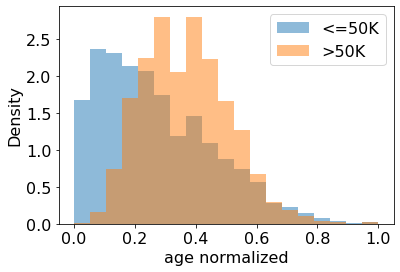

In [44]:
# plot feature distribution based on income
feature_idx = 0 # age

if t == 'zscore':
    bins = np.linspace(-2, 4, 40)
elif t == 'normalized':
    bins = np.linspace(0, 1, 20)
else:
    bins = 20

inc0_idx = train_y == 0
inc1_idx = train_y == 1

plt.hist(train_x[inc0_idx,feature_idx], bins, density=True, alpha=0.5, label=income_list[0])
plt.hist(train_x[inc1_idx,feature_idx], bins, density=True, alpha=0.5, label=income_list[1])

plt.xlabel('{} {}'.format(col_names[feature_idx], t))
plt.ylabel('Density')

plt.legend(loc='upper right')
plt.show()

## [Task 3] (20 points): Correlations

### [Task 3a] (5 points) Plot a heatmap of (pairwise) correlation between features and labels (see exercise 1)

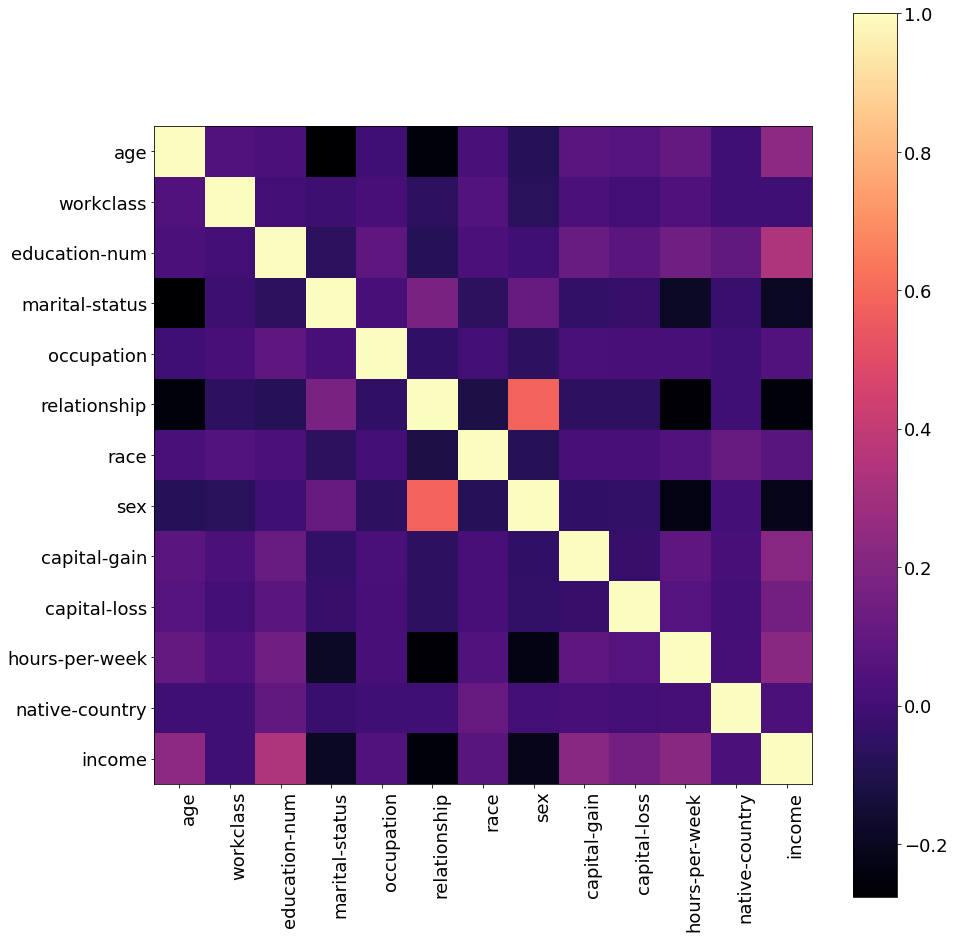

In [45]:
###* Put your code below *###

train_xy = np.hstack((train_x, train_y.reshape(-1, 1)))

pairwise_corr = np.corrcoef(train_xy, rowvar=False)

plots.heatmap(pairwise_corr, col_names, col_names, rot=90, fsz=(14, 14))

### [Task 3b] (10 points) What do you observe? Which features are correlated with the label?

In [46]:
###* Put your answer as a comment ###
#
#
# Several features have weak positive and negative correlations with income. For example
# positive correlations include: age, education-num, capital-game, hours-per weeks
# (slight) negative correlations include marital status, relationship, and sex
# education-num seems to have the highest correlation
# note: some features are correlated with each other (e.g., sex and relationship)

### [Task 3c] (5 points) Given that some features like workclass, marital-status, race, sex are categorical, is the Pearson correlation coefficient a good measure of statistical relationship? If yes, explain why. If not, explain why not *and* propose (in brief) an alternative.

In [47]:
###* Put your answer as a comment ###
#
#
# It's not the best metric, but it does give us some idea.
# One reason is that values of categorical attributes 
# are not necessarily ordered and thus it's not clear what the correlation coefficient tell us in this case
# There are many other (better) metrics we could use for categorical features (e.g., conditional entropy / information gain)
#

## Part 2: Let's train some models!

## [Task 4] (30 points): Learning Curves

### [Task 4a] (10 points): Complete the definition of the subsample_train_eval function which repreatedly trains a model using a subset of the train data and calculates training & validation accuracy

In [48]:
from sklearn.base import clone

def model_accuracy(model, x, true_y):
    pred = model.predict(x)
    return np.sum(pred == true_y) / true_y.shape[0]

###* Put your code below *###
def subsample_train_eval(model, train_x, train_y, val_x, val_y, sample_size, num_repeats=10):
    
    train_accs = np.zeros((num_repeats,1))
    val_accs = np.zeros_like(train_accs)
    
    rng = np.random.default_rng()
    for i in range(0, num_repeats):
        m = clone(model) # clone the model
        
        # take sample_size random records from train_x (and train_y) and fit m on it
        ###* Put your code here *###
        
        # the key here is to make sure that you take the same rows (i.e., examples) 
        # in both train_x and train_y when sampling 
        # (if not it will break association between features and label and the resulting model won't learn)
        
        # a simple way to achieve this is to first take a random permutation of the integers 0, 1, ..., n-1 
        # (where n is the size of the training set)
        pi = rng.permutation(train_x.shape[0])
        
        # and then take a random subset (of the appropriate size) of this permutation
        pi = pi[0:sample_size]
        
        # Finally we use the random subset to index into train_x and train_y 
        tr_x = train_x[pi]
        tr_y = train_y[pi]
        
        m.fit(tr_x, tr_y)
        
        # get the accuracies
        train_accs[i] = model_accuracy(m, tr_x, tr_y)
        val_accs[i] = model_accuracy(m, val_x, val_y)
        
    return train_accs, val_accs

In [49]:
def plot_learning_curve(model_instance, model_name, train_x, train_y, val_x, val_y, train_szs=None):
    
    if train_szs is None:
        train_szs = np.array([25, 50, 100, 200, 300, 500, 750, 1000, 1500, 2000])
        
    num_datapoints = train_szs.shape[0]
    accs = np.zeros((num_datapoints,2))
    laccs = np.zeros((num_datapoints,2))
    uaccs = np.zeros((num_datapoints,2))
    
    sys.stdout.write('Plotting')

    for i, tsz in enumerate(train_szs):
        
        nr = 20 if tsz <= 1000 else 10
        train_accs, val_accs = subsample_train_eval(model_instance, train_x, train_y, val_x, val_y, tsz, num_repeats=nr)
        
        train_acc = np.mean(train_accs)
        train_acc_std = np.std(train_accs)
        
        accs[i,0] = train_acc
        laccs[i,0] = train_acc - train_acc_std
        uaccs[i,0] = train_acc + train_acc_std
        
        val_acc = np.mean(val_accs)
        val_acc_std = np.std(val_accs)
        
        accs[i,1] = val_acc
        laccs[i,1] = val_acc - val_acc_std
        uaccs[i,1] = val_acc + val_acc_std
        
        sys.stdout.write('.')
        sys.stdout.flush()
    print()
    
    fig, ax = plt.subplots(figsize=(15,8))

    plt.fill_between(train_szs, laccs[:,0]*100.0, uaccs[:,0]*100.0, color='r', alpha=0.3)
    plt.fill_between(train_szs, laccs[:,1]*100.0, uaccs[:,1]*100.0, color='b', alpha=0.3)
    
    plt.plot(train_szs, accs[:,0]*100.0, 'ro-', linewidth=3, label='Training')
    plt.plot(train_szs, accs[:,1]*100.0, 'bs--', linewidth=3, label='Validation')

    ax.set_xlim(0, np.max(train_szs))
    ax.set_ylim(65, 104)
    ax.set_xlabel('Number of training examples')
    ax.set_ylabel('Accuracy')
    ax.set_title('Learning Curves for {}'.format(model_name))

    plt.legend()

    plt.show()

### [Task 4b] (10 points): Complete the code of the cell below to plot the learning curves

Plotting..........


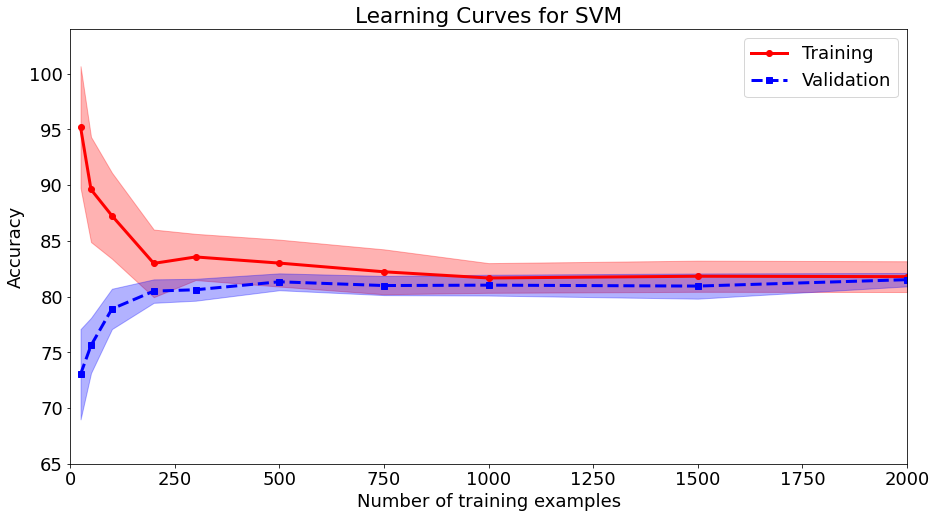

Plotting..........


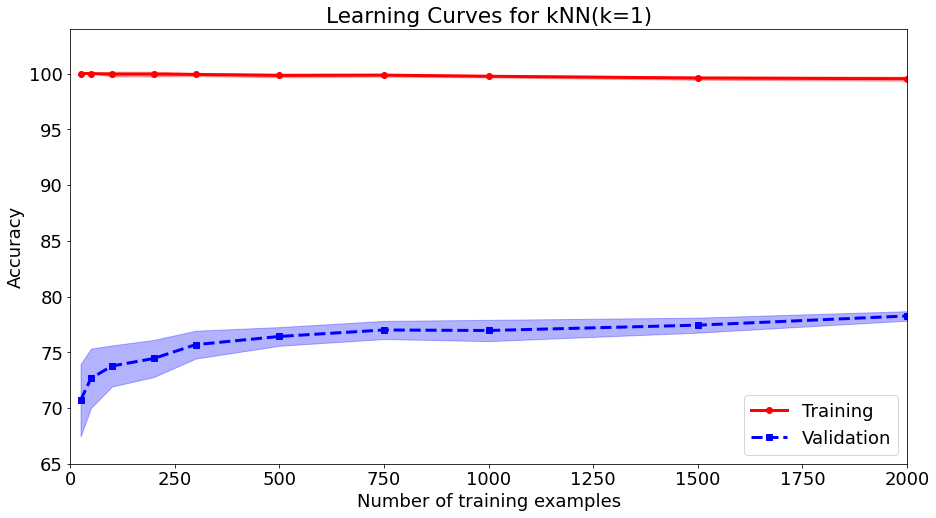

In [50]:
# Let's import what we need from scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

# grab the zscore normalized version of the data
train_x, train_y, test_x, test_y, val_x, val_y = grab_data('zscore')

###* put your code here: instantiate a linear SVM model (SVC with a linear kernel) with default hyperparameters and plot its learning curve *###
###* note: you just need to call 'plot_learning_curve' with the correct arguments
plot_learning_curve(SVC(kernel='linear'), 'SVM', train_x, train_y, val_x, val_y)
    

###* put your code here: instantiate a KNN (k=1) model with default hyperparameters and plot its learning curve *###
###* note: again, you just need to call 'plot_learning_curve' with the correct arguments
plot_learning_curve(KNeighborsClassifier(n_neighbors=1), 'kNN(k=1)', train_x, train_y, val_x, val_y)   

### [Task 4c] (10 points): What can you conclude about the size of the training data necessary for both the SVM model and the KNN model? If you had to choose between the SVM and the KNN, which would you pick and why?

In [40]:
###* Put your answer as a comment ###
#
#
#
# Performance for both plateaus at around 750 to 1000 examples. 
# More data could still help increase accuracy a little bit (maybe 2 or 3%) but it is unlikely to make a much larger difference
#
# SVM is a clear better choice in this case because KNN performance on validation set is much lower (also it overfits).

## [CIS6930 Additional Task -- Task 5] (25 points): Analysis of feature engineering

### [Task 5a] (10 points): Train SVM and kNN models as in Task 4 for min-max normalized and zscore normalized features (not one-hot encoded) and compare them (print accuracies, bar plot, whatever you think is appropriate). Use the full training set (no learning curves). What do you conclude and why?

In [46]:
###* Put your code here *###
#
def evaluate_model(name, model, train_x, train_y, val_x, val_y):
    train_acc = model_accuracy(model, train_x, train_y)
    val_acc = model_accuracy(model, val_x, val_y)
    print('[{}] Training accuracy: {:.2f}%, Validation accuracy: {:.2f}%'.format(name, train_acc*100, val_acc*100))
    
    
## this code just iterates over the different versions of the data, train the SVM and KNN models, and evaluate them.
ts = ['zscore', 'normalized']
for t in ts:
    train_x, train_y, _, _, val_x, val_y = grab_data(t)
    
    svm = SVC(kernel='linear').fit(train_x, train_y)
    knn = KNeighborsClassifier(n_neighbors=1).fit(train_x, train_y)
    
    evaluate_model('{} SVM'.format(t), svm, train_x, train_y, val_x, val_y)
    evaluate_model('{} KNN'.format(t), knn, train_x, train_y, val_x, val_y)
    print()

[zscore SVM] Training accuracy: 81.07%, Validation accuracy: 81.41%
[zscore KNN] Training accuracy: 96.87%, Validation accuracy: 79.62%

[normalized SVM] Training accuracy: 81.20%, Validation accuracy: 81.38%
[normalized KNN] Training accuracy: 96.82%, Validation accuracy: 79.14%



In [42]:
###* Put your answer as a comment ###
#
#
# There does not seem to be a significant difference between standardization (z-score normalization) 
# and normalization (min-max normalization)! 
# This is actually not surprising, in most cases they tend to give similar results 
# (although there are some cases where one is clearly preferable to the other, for example if you have gaussian features you would use zscore)
#

### [Task 5b] (15 points): Now repeat the analysis but this time compare the one-hot encoded features to non-one-hot encoded features. Use the full training set (no learning curves). What is the impact on the models (for both SVM & kNN) of one-hot encoding? Briefly comment on your findings.

In [43]:
###* Put your code here *###
#
ts = ['zscore', 'onehot_z', 'normalized', 'onehot_n']

## this code just iterates over the different versions of the data, train the SVM and KNN models, and evaluate them.
for t in ts:
    train_x, train_y, _, _, val_x, val_y = grab_data(t)
    
    svm = SVC(kernel='linear').fit(train_x, train_y)
    knn = KNeighborsClassifier(n_neighbors=1).fit(train_x, train_y)
    
    evaluate_model('{} SVM'.format(t), svm, train_x, train_y, val_x, val_y)
    evaluate_model('{} KNN'.format(t), knn, train_x, train_y, val_x, val_y)
    print()
        

[zscore SVM] Training accuracy: 81.07%, Validation accuracy: 81.41%
[zscore KNN] Training accuracy: 96.87%, Validation accuracy: 79.62%

[onehot_z SVM] Training accuracy: 84.88%, Validation accuracy: 85.14%
[onehot_z KNN] Training accuracy: 97.86%, Validation accuracy: 80.58%

[normalized SVM] Training accuracy: 81.20%, Validation accuracy: 81.38%
[normalized KNN] Training accuracy: 96.82%, Validation accuracy: 79.14%

[onehot_n SVM] Training accuracy: 84.95%, Validation accuracy: 84.90%
[onehot_n KNN] Training accuracy: 97.40%, Validation accuracy: 79.36%



In [44]:
###* Put your answer as a comment ###
#
# In this case, we observe that one-hot encoding is resulting in a significantly better model 
# (3 to 4% higher validation accuracy)!
#
# This shows that feature engineering can lead to significant difference in performance
# Note: 85% is about state-of-the-art for Adult (it's hard to do much better; I have seen maybe a handful of models that can achieve 86% or 87%).
#